In [1]:
import pandas as pd
import json
from datetime import datetime, timedelta
import numpy as np
from scipy.integrate import odeint
from decimal import Decimal

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

### Load the data

In [3]:
#number inhabitants italy
N_inhabitants = 60.48e6 

#Susceptible people, i.e. people that are really in contact with each other, should be a percentage of
#the number of inhabitants
percentage = 0.75

N = N_inhabitants * percentage

print("Number of susceptible people:", round(N * 1e-6, 2), "million")

with open("./COVID-19/dati-json/dpc-covid19-ita-andamento-nazionale.json") as f:
        dataset = json.load(f)
        
#days = range(len(dataset))
num_casi = []

days = []

for item in dataset:
    num_casi.append(item['totale_casi'])
    
    #convert to datetime
    days.append(datetime.strptime(item['data'], '%Y-%m-%d %H:%M:%S'))

Number of susceptible people: 45.36 million


In [4]:
# Initial number of infected and recovered individuals (in date 2-24-2020)

I0 = dataset[0]['totale_casi']
R0 = dataset[0]['dimessi_guariti']
        
# Number of people susceptible to infection initially.
S0 = N - I0 - R0

# Initial conditions vector
y0 = S0, I0, R0

### Compare real data and model

In [5]:
t = np.linspace(0, len(days), len(days))

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta_low = 0.27
gamma_low = 1./15.

R0_low =  beta_low/gamma_low

print("R0_low:", round(R0_low, 4))

#herd_immune threshold
print("HIT low:",  round(1. - (1/R0_low), 3))

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta_low, gamma_low))
S_low, I_low, R_low = ret.T

beta_high = 0.275
gamma_high = 1./15.

R0_high =  beta_high/gamma_high

print("R0_high:", round(R0_high, 4))
print("HIT high:",  round(1. - (1/R0_high), 3))

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta_high, gamma_high))
S_high, I_high, R_high = ret.T

R0_low: 4.05
HIT low: 0.753
R0_high: 4.125
HIT high: 0.758


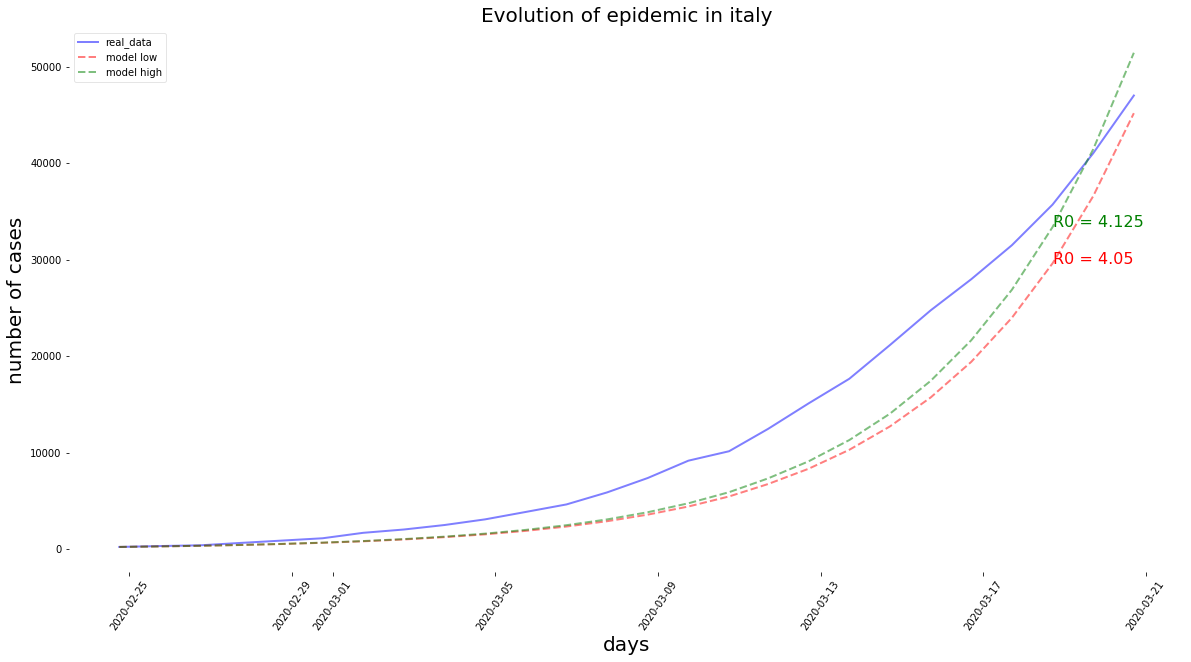

In [10]:
fig = plt.figure(facecolor='w', figsize=(20,10))

ax = fig.add_subplot(111, axisbelow=True)

ax.plot(days, num_casi, 'b', alpha=0.5, lw=2, label='real_data')
ax.plot(days, I_low, 'r', alpha=0.5, lw=2, label='model low', linestyle='dashed')
ax.plot(days, I_high, 'g', alpha=0.5, lw=2, label='model high', linestyle='dashed')

ax.text(days[-3], I_low[-3], "R0 = " + str(round(R0_low, 4)), fontsize=16,
               rotation=0, rotation_mode='anchor', color='red')

ax.text(days[-3], I_high[-3], "R0 = " + str(round(R0_high, 4)), fontsize=16,
               rotation=0, rotation_mode='anchor', color='green')


#ax.plot(t, num_casi, 'b', alpha=0.5, lw=2, label='real_data')
#ax.plot(t, I_low, 'r', alpha=0.5, lw=2, label='model low')
#ax.plot(t, I_high, 'g', alpha=0.5, lw=2, label='model high')

plt.title('Evolution of epidemic in italy', fontsize=20)

ax.set_xlabel('days', fontsize=20)
ax.set_ylabel('number of cases', fontsize=20)

#plt.xticks(rotation=90)

ax.xaxis.set_tick_params(rotation=55)

#ax.yaxis.set_tick_params(length=0)
#ax.xaxis.set_tick_params(length=0)

ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.savefig("images/evolution.png")
#plt.show()

### Predict future trend

In [11]:
num_days = 150

t = np.linspace(0, num_days, num_days)

# Integrate the SIR equations over the time grid, t.
#ret = odeint(deriv, y0, t, args=(N, beta_low, gamma_low))

ret = odeint(deriv, y0, t, args=(N, beta_high, gamma_high))

S, I, R = ret.T

In [12]:
#create datetimes for future

days_future = []

date = datetime.strptime(dataset[0]['data'], '%Y-%m-%d %H:%M:%S')
time_step = timedelta(days=1)

for day in range(len(t)):
#for day in range(2):
    
    days_future.append(date)     
    date += time_step

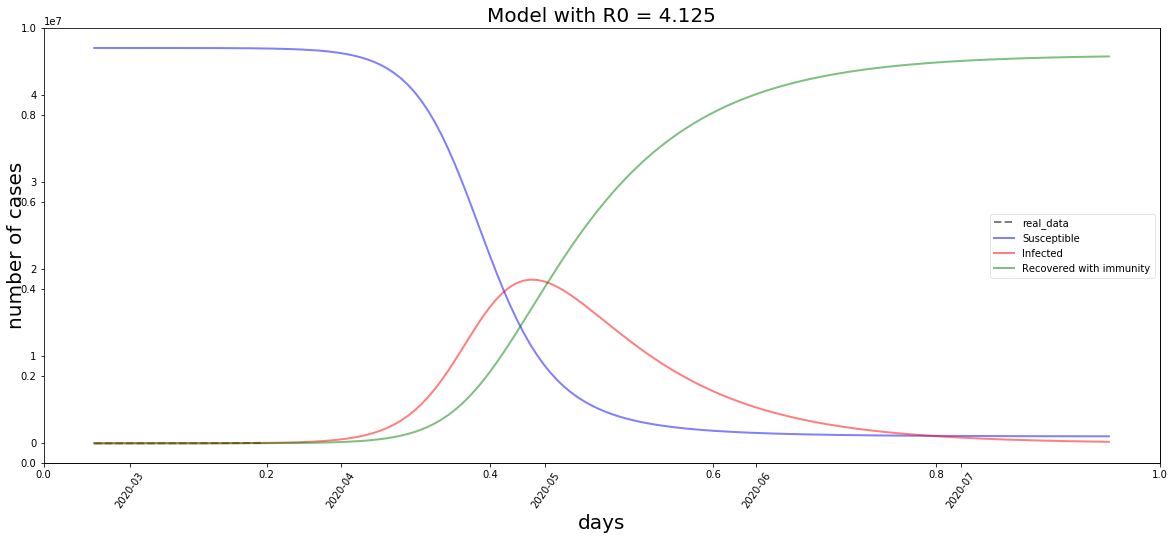

In [13]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w', figsize=(20,8))

plt.title('Model with R0 = ' + str(round(beta_high/gamma_high, 3)), fontsize=20)

ax = fig.add_subplot(111, axisbelow=True)

ax.plot(days, num_casi, 'black', alpha=0.5, lw=2, label='real_data', linestyle='dashed')
ax.plot(days_future, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(days_future, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(days_future, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

ax.set_xlabel('days', fontsize=20)
ax.set_ylabel('number of cases', fontsize=20)

#ax.yaxis.set_tick_params(length=0)
#ax.xaxis.set_tick_params(length=0)

ax.xaxis.set_tick_params(rotation=55)

#ax.grid(b=True, which='major', c='w', lw=2, ls='-')

legend = ax.legend()
legend.get_frame().set_alpha(0.5)

#for spine in ('top', 'right', 'bottom', 'left'):
#    ax.spines[spine].set_visible(False)

plt.savefig("images/modelling.png")

plt.show()